<a href="https://colab.research.google.com/github/norebese/kdt-task/blob/main/20_%EA%B0%84%EB%8B%A8%ED%95%9C_CNN_%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 배치크기 * 채널(1: 그래이스케일, 3: 컬러) * 너비 * 높이
inputs = torch.Tensor(1, 1, 28, 28)
print(inputs.shape)

torch.Size([1, 1, 28, 28])


In [3]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [4]:
# 첫번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [5]:
# 두번째 Conv2D
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [6]:
# 두번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [7]:
flatten = nn.Flatten()
out = flatten(out)
print(out.shape) # 64 * 7 * 7

torch.Size([1, 3136])


In [8]:
fc = nn.Linear(3136, 10)
out = fc(out)
print(out.shape)

torch.Size([1, 10])


### CNN으로 MNIST 분류하기

In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4588065.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134476.13it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 272598.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5334788.23it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [12]:
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [13]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


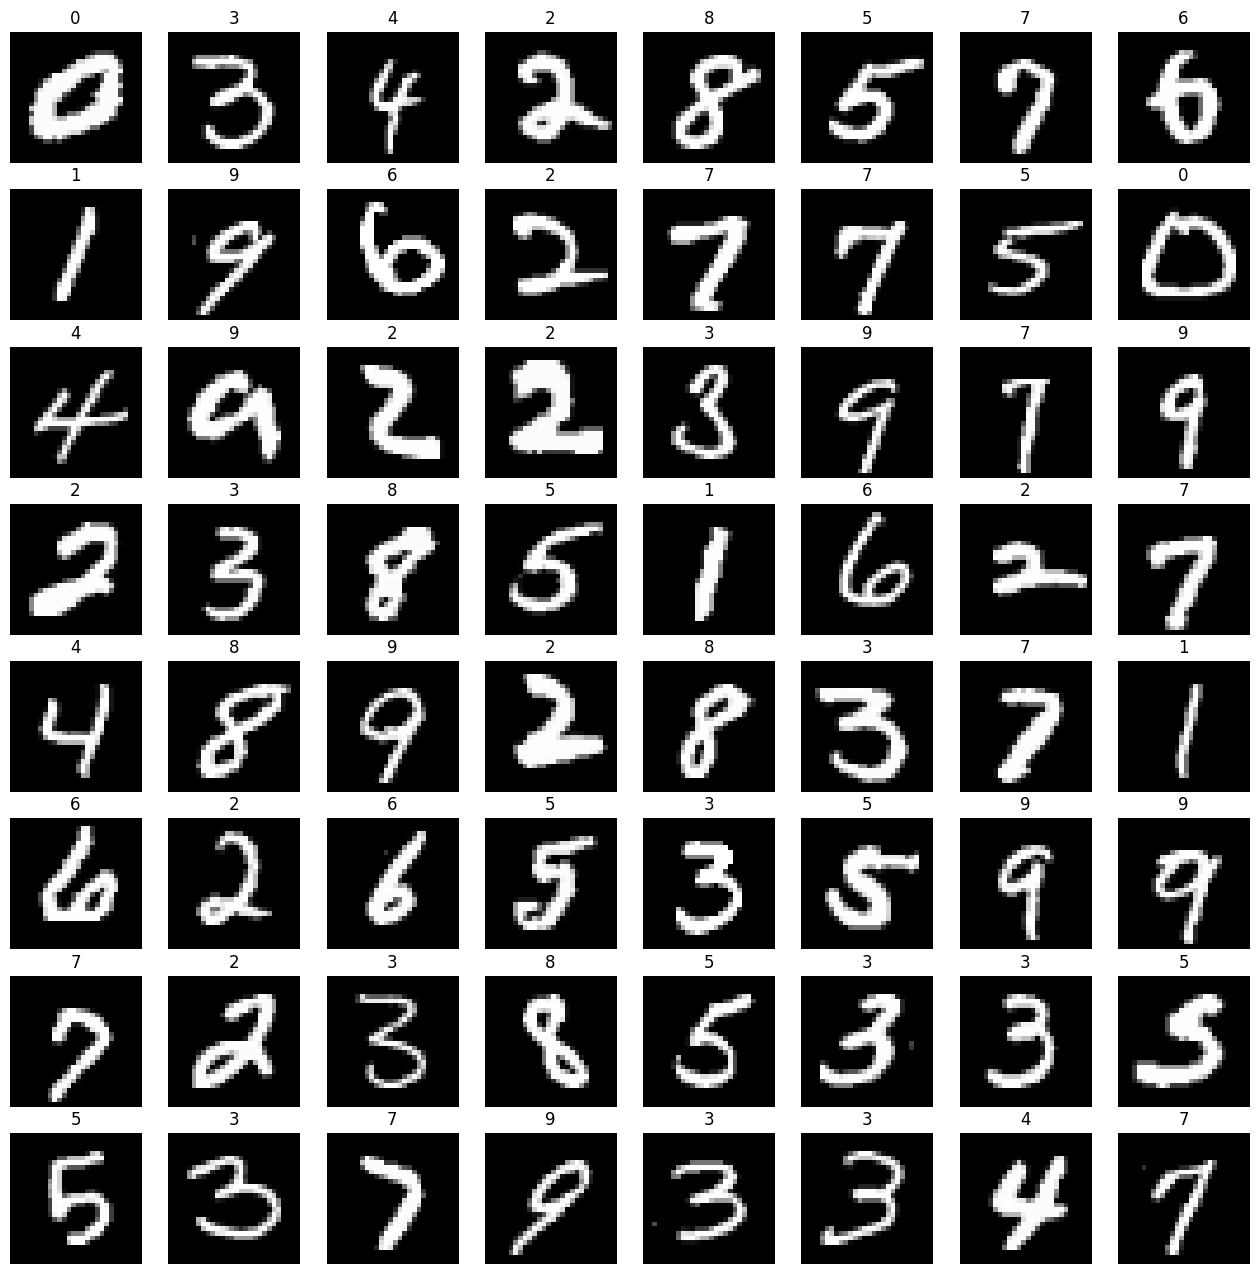

In [14]:
loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

imgs, labels = next(iter(loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [15]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 10)
 ).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)


In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc
    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)
    print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    0/10 Loss: 0.178853 Accuracy: 94.68%
Epoch    1/10 Loss: 0.057020 Accuracy: 98.25%
Epoch    2/10 Loss: 0.040907 Accuracy: 98.71%
Epoch    3/10 Loss: 0.032722 Accuracy: 98.93%
Epoch    4/10 Loss: 0.025639 Accuracy: 99.16%
Epoch    5/10 Loss: 0.021898 Accuracy: 99.31%
Epoch    6/10 Loss: 0.017690 Accuracy: 99.44%
Epoch    7/10 Loss: 0.014877 Accuracy: 99.53%
Epoch    8/10 Loss: 0.011964 Accuracy: 99.62%
Epoch    9/10 Loss: 0.010604 Accuracy: 99.64%


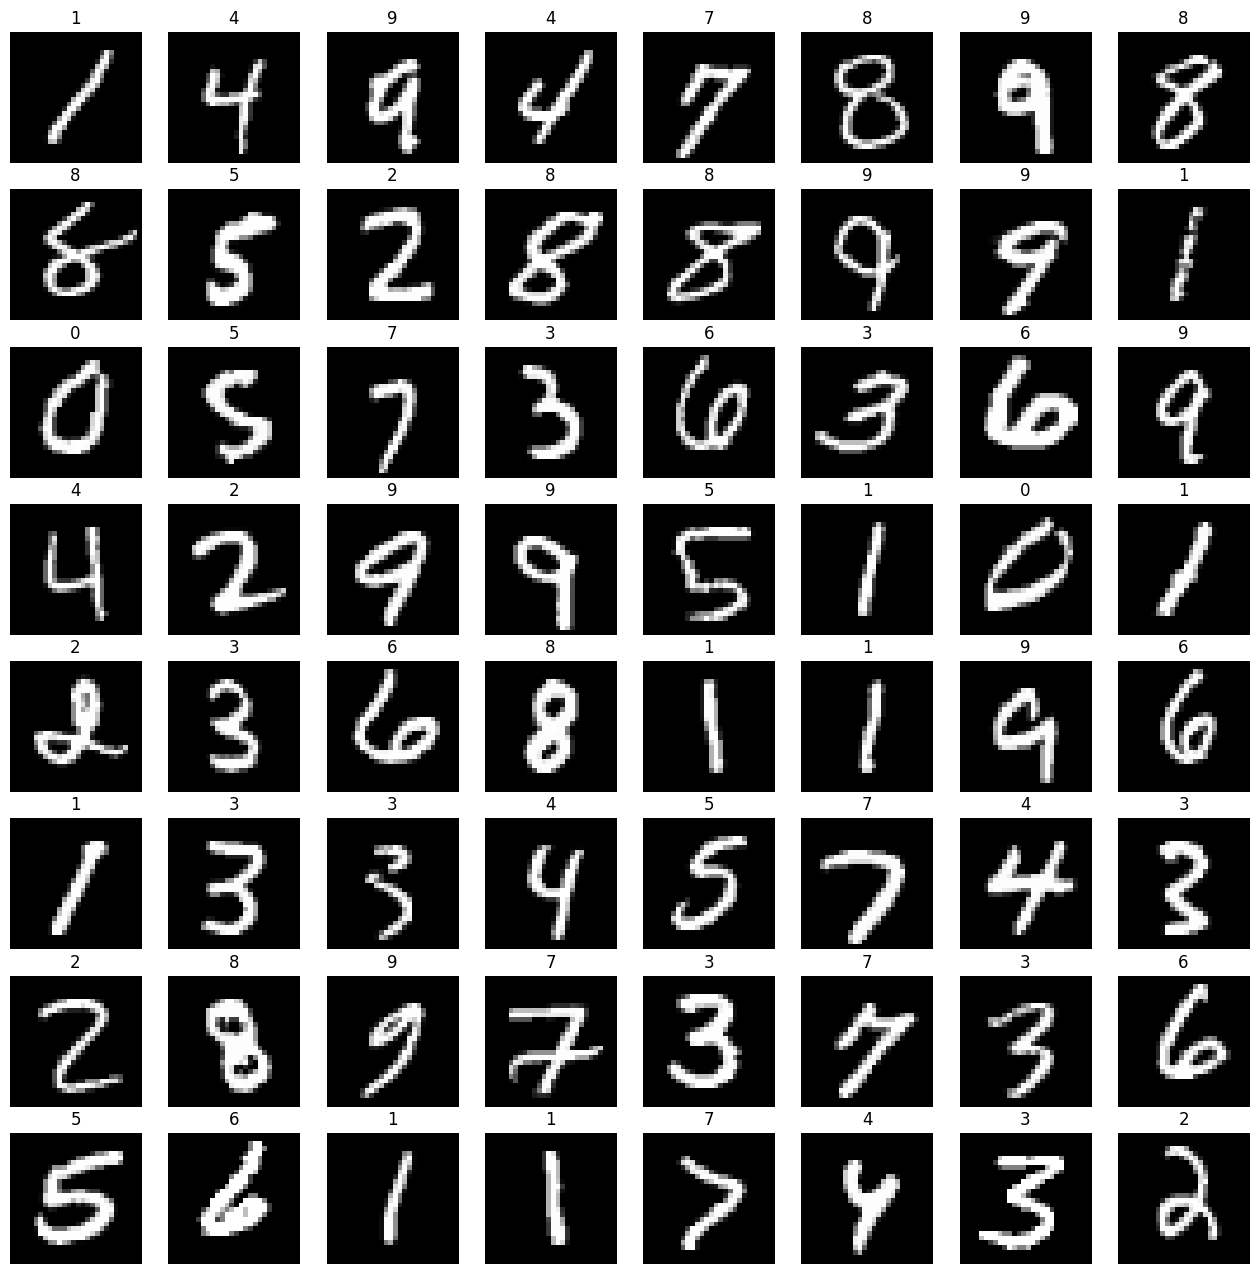

In [17]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [18]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs = 0

for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_acc = sum_accs / len(test_loader)
print(f'Test Accuracy: {avg_acc:.2f}%')

Test Accuracy: 98.89%


### 0, X, 세모 을 그림판에 여러가지 이미지를 저장 후 CNN으로 학습을 시켜 해당 데이터를 분류를 하는 모델을 만들어보자.

